# 사람이 말하는 단어를 인공지능 모델로 구분하기
---------------

* 2차원 Spectrogram 데이터를 입력받아 모델을 수행해보기

## 1. 데이터 처리와 분류

### 라벨 데이터 처리하기

In [1]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [12]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

In [34]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [35]:
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  9152
Wave data shape :  (8000,)
label :  ['off']


#### 2차원으로 변환

In [36]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [37]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


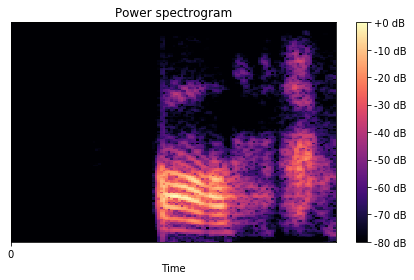

In [38]:
import librosa.display
import matplotlib.pyplot as plt

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

### sklearn의 train_test_split함수를 이용하여 train, test 분리

In [39]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, sc, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, sc, 1])
print("✅")

[[-5.05718781e-05 -1.06505075e-04 -7.01054887e-05 ...  8.10494748e-05
  -3.84372761e-05  1.83005934e-04]
 [-4.12032753e-03 -6.61706692e-03 -5.12852333e-03 ... -7.48969289e-03
  -1.01831295e-02 -6.63286913e-03]
 [-2.50520476e-04 -5.71950048e-04 -6.99084892e-04 ...  1.40505750e-03
   1.35156966e-03  8.96949437e-04]
 ...
 [-1.95537417e-04 -1.05768954e-03 -2.12599454e-03 ...  2.82644248e-03
   2.69283587e-03  1.89975789e-03]
 [ 3.29858065e-03  4.64028632e-03  4.51567685e-05 ...  2.59920536e-03
   2.14636372e-03 -1.76150445e-03]
 [ 7.25417456e-04  1.68988004e-03  8.00192764e-04 ...  2.86653638e-03
   5.93604287e-03  9.29154735e-03]]


NameError: name 'sc' is not defined

## 2. 학습을 위한 하이퍼파라미터 설정

In [20]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel/aiffel/speech_recognition/models/wav'

## 3. 데이터셋 구성

* tf.data.Dataset을 이용       
* from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용     
* map과 batch를 이용한 데이터 전처리      
* 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있다.     

tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 된다.

```python
del speech_data
del spec_data
```

In [21]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


In [22]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


In [23]:
del speech_data
del spec_data

NameError: name 'spec_data' is not defined

## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

* 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
* batchnorm, dropout, dense layer 등을 이용
* 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
* 모델 가중치를 저장하는 checkpoint callback 함수 추가
* 다양한 모델의 실험을 진행해 보기

#### Wave classification 모델 

In [41]:
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

input_tensor = layers.Input(shape=(None, 8000, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

ValueError: The last dimension of the inputs to `Dense` should be defined. Found `None`.

In [42]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

NameError: name 'model_wav' is not defined

In [43]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [44]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

NameError: name 'model_wav' is not defined

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

* loss, accuracy를 그래프로 표현 

In [ ]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## 6. Test dataset을 이용해서 모델의 성능을 평가

* 저장한 weight 불러오기
* 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [ ]:
model_wav.load_weights(checkpoint_dir)
results = model_wav.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

In [ ]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

In [ ]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

## 회고하며..

일단 노드에서 잔뜩 가져왔는데 error 따라서 하나 둘 고치다가 안풀리고 시간은 가고 해서 금요일쯤에 마음 차분히 먹고 다시 봐야겠다.     
일단은 자야지,,